# Rewritting of Benedikt's Kitaev Code into Interactive 

Housekeeping, I obelieve it will be more instructive to carry in this manner!

## Some Initial Definitions

In [49]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting

In [50]:
# define enum just for just for better readibility of code
@enum PauliType begin
    PauliX = 1
    PauliY = 2    
    PauliZ = 3
end

In [51]:
function bit_string_ij(i::Integer, j::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at position i and j.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    @assert(i != j);
    str = zeros(Bool, n);
    str[i] = true;
    str[j] = true;
    return str
end

function pauli_ij(t::PauliType, i::Integer, j::Integer, n::Integer)
    """returns a two-body-pauli of given type, acting on positions i and j in a n-qubit system"""
    bits = bit_string_ij(i, j, n);

    if t == PauliX::PauliType
        return PauliOperator(0x0, bits, zeros(Bool, n));
    elseif t == PauliZ::PauliType 
        return PauliOperator(0x0, zeros(Bool, n), bits); 
    else
        return PauliOperator(0x0, bits, bits);
    end
end

pauli_ij (generic function with 1 method)

## The main functions used to define the simulations

In [52]:
function run_measurement_only_dynamics!(state::MixedDestabilizer,
    get_random_pauli::Function,
    nt::Integer,
    measure_ts::AbstractArray)
"""this runs the mesaurement only dynamics. 
state            : state to be evolved. It is taken by reference (hence the ! in the name by convention).
get_random_pauli : a function that is called each time step and should generate the paulis to be measured.
nt               : the total number of time steps (one time step is defined as number-of-sites measurements
measure_ts       : times at which entropy is measured)
"""

# get system size n (number of qubits)
n = size(stabilizerview(state))[2]
# this will store the total entropy (con Neumann) as a function of time
entropies = Vector{Float64}([entanglement_entropy(state, 1:n, Val(:clip))])

# now perform nt measurement sweeps
for t in 1:nt
  for tt in 1:n
  # projectrand randomizes also the measurement outcomes
  projectrand!(state,             # state to measure
  get_random_pauli() # the model is fully defined by this function
  )
  end
  if t > measure_ts[length(entropies)]
  # calculate the full van-neumann entropy of the system
  s = entanglement_entropy(state,     # state to compute entropy for
    1:n,       # subsystem as list of indices. Specifying full subsystem gives the van-neumann entropy
    Val(:clip) # algorithm to use (see documentation)
    )
  push!(entropies, s)
  end
end

return entropies 
end

run_measurement_only_dynamics! (generic function with 1 method)

In [53]:
function random_honeycomb_kitaev_pauli(L, pauli_type_dist::DiscreteNonParametric)
    """this defines the kitaev model. For any other (qubit) model changing this function should in principle suffice."""

    ncells = L*L

    # get a random cell to measure
    # note that cell going from 0 to ncells-1 is against typical julia convention, which indexes starting from 1
    random_cell = rand(0:(ncells-1)) 

    # get the first site of the bond to measure 
    i = 2 * random_cell + 2

    # get a random pauli type (not the conversion since rand(pauli_type_dist) generates a number between 1 and 3)
    pauli_type::PauliType = PauliType(rand(pauli_type_dist));

    if pauli_type == PauliX::PauliType
        # X bond is the one in the same cell     
        j = 2 * (random_cell) + 1
    elseif pauli_type == PauliY::PauliType
        # for Y we have to work harder and get the neighboring unit cell
        nx = mod(random_cell, L);
        ny = div(random_cell, L);
        # +1 is needed since again, julia indices start from 1
        j = 2 * (ny * L + mod(nx + 1, L)) + 1 
    else  # Pauli Z case
        nx = mod(random_cell, L);
        ny = div(random_cell, L);
        j = 2 * (mod(ny + 1, L) * L + nx) + 1
    end
    
    # now return the respective pauli operator
    return pauli_ij(pauli_type, i, j, 2 * ncells)
end

random_honeycomb_kitaev_pauli (generic function with 1 method)

## The Simulation

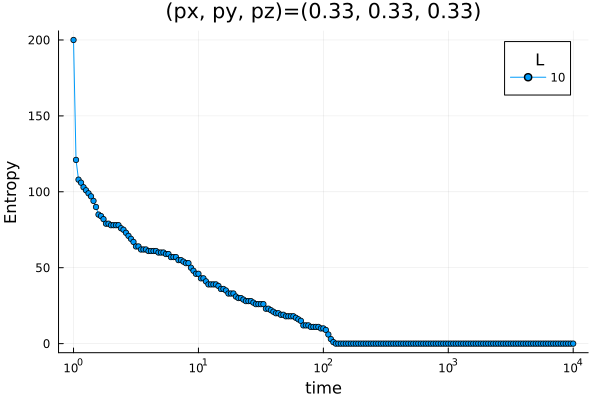

(px, pz) : (0.3333333333333333 0.3333333333333333)
L        : 10
nt       : 10000
outfile  : data/kitaev_out.h5
nmeasure : 201


In [54]:
# Unwrap the main function to be run interactively

px = 1/3  # measurement probabilities
py = 1/3
pz = 1/3
L = 10  # linear system size
nt = Int(1e4)  # total number of time steps to evolve
outfname = "data/kitaev_out.h5"  # file to write output to (hdf5 format)
nmeasure = 201 # number of measurements (log-spaced in time)

println("(px, pz) : (", px, " ", pz, ")",
        "\nL        : ", L,
        "\nnt       : ", nt,
        "\noutfile  : ", outfname,
        "\nnmeasure : ", nmeasure)


# Distribution of pauli types as given
# this just returns 1, 2, 3 with the give probabilities 
pauli_dist = Categorical([px, py, pz])

# times at which to measure stuff
measure_ts = exp10.(range(0, log10(nt+1), length=nmeasure))

# initial state is the maximally mixed state
# since the package does not let you create an empty tableau, I defined the identity as the stabilizer, which is the same statement
nbits = 2*L^2
maximally_mixed_state = Stabilizer(zeros(UInt8, 1), # phases
                                zeros(Bool, 1, nbits), # Z Tableau (as matrix of bool)
                                zeros(Bool, 1, nbits) # X Tableau
                                );

# this is running the actual dynamics simulation
entropy_t = run_measurement_only_dynamics!(MixedDestabilizer(maximally_mixed_state), # evolve this
                                        () -> random_honeycomb_kitaev_pauli(L, pauli_dist),  # bind 
                                        nt,
                                        measure_ts)

# create the parent directory for output file
if !ispath(dirname(outfname))
    mkpath(dirname(outfname))
end

# write output to hdf5
h5open(outfname, "w") do outfile
    write(outfile, "px", px)
    write(outfile, "pz", pz)
    write(outfile, "L", L)
    write(outfile, "N", nbits)
    write(outfile, "entropy", entropy_t)
    write(outfile, "time", measure_ts)
end


# plot entropy as function of time
p = plot(measure_ts, entropy_t,
    title=format("(px, py, pz)=({:.2f}, {:.2f}, {:.2f})", px, py, pz),
    xlabel="time",
    ylabel="Entropy",
    marker=(:circle, 3),
    xscale=:log10,
    legendtitle="L",
    label=L)
# gui()  # this is the equivalent of matplotlibs show()
# Note: not needed since we are plotting in the cell (with added name to the plot "p")
display(p)